<a href="https://colab.research.google.com/github/IamSVP94/cv_assignments/blob/main/CV_Imagewoof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade
!pip install torch

In [ ]:
from fastai.vision.all import URLs, untar_data

import matplotlib.pylab as plt
import albumentations as A
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

from pathlib import Path
import torch
from torch.utils.data import random_split, DataLoader, TensorDataset
import torchvision.models as models
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
path = untar_data(URLs.IMAGEWOOF)

csv = pd.read_csv('https://raw.githubusercontent.com/fastai/imagenette/master/noisy_imagewoof.csv')
csv['path'] = [Path(path, line) for line in csv['path']]
csv = csv[['path', 'noisy_labels_0', 'is_valid']]
csv.rename(columns={'noisy_labels_0': 'label'}, inplace=True)

In [ ]:
csv['label'].value_counts()  # классы более-менее сбалансированы

n02088364    1350
n02086240    1350
n02099601    1350
n02115641    1350
n02105641    1350
n02111889    1350
n02087394    1350
n02093754    1350
n02096294    1350
n02089973     804
Name: label, dtype: int64

In [ ]:
label_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

labels = list(label_dict.keys())

In [ ]:
train_csv = csv[csv['is_valid']==False]
train_csv = train_csv.sample(frac=1).reset_index(drop=True)
del train_csv['is_valid']


val_csv = csv[csv['is_valid']==True]
val_csv = val_csv.sample(frac=1).reset_index(drop=True)
del val_csv['is_valid']

test_size = int(len(val_csv)*0.1)
test_csv = val_csv[:test_size]
val_csv = val_csv[test_size:]

In [ ]:
def resizer(img, df=csv, mode='original'):
    assert mode in ['original', 'train', 'val'], 'Неизвестный режим resizer'
    label = df[df['path']==img]['label'].item()
    label = label_dict[label]
    img_bgr = cv2.imread(str(img))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    
    if mode == 'train':
        transform = A.Compose([
            A.HorizontalFlip(p=0.5), 
            A.ShiftScaleRotate(rotate_limit=15, scale_limit=0, p=0.5), 
            A.HueSaturationValue(p=0.5),
            ], p=0.5)
        return {'img': cv2.resize(transform(image=img_rgb)['image'], (100, 100)), 'label': label}
    elif mode == 'val':
        return {'img': cv2.resize(img_rgb, (100, 100)), 'label': label}
    else:
        return {'img': img_rgb, 'label': label}

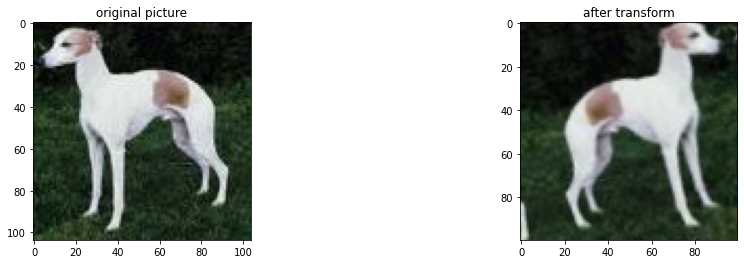

In [ ]:
img = csv['path'][np.random.randint(len(csv))]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
ax[0].imshow(resizer(img)['img'])
ax[1].imshow(resizer(img, mode='train')['img'])
ax[0].set_title('original picture')
ax[1].set_title('after transform');

In [ ]:
torch.manual_seed(2) # for reproducibility
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 30  # ресурсы колаба ограничены
batch_size=256
start_learning_rate = 1e-2

n_classes = len(labels)

net = models.resnet50(pretrained=True).to(device)
net.fc = torch.nn.Linear(net.fc.in_features, n_classes).to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = start_learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, eps=1e-9, verbose=True)

train_history = []
val_history = []
val_accuracy = []

In [ ]:
def df_to_DataLoader(df, batch_size=batch_size, mode='val'):
    transform = A.Compose([
            A.HorizontalFlip(p=1), 
            A.ShiftScaleRotate(rotate_limit=15, scale_limit=0, p=0.5), 
            A.HueSaturationValue(p=0.5),
            ], p=1)
    imgs_list = []
    gt = []
    for i, (path, label) in tqdm(df.iterrows(), total=len(df), leave=False):
        img = resizer(path, mode='val')["img"]
        target = labels.index(label)
        imgs_list.append(img.reshape(3, 100, 100))
        gt.append(target)
        if mode=='train':  # augmentation
          aug_img = cv2.resize(transform(image=img)['image'], (100, 100))
          imgs_list.append(aug_img.reshape(3, 100, 100))
          gt.append(target)
    dataset = TensorDataset(torch.Tensor(imgs_list), torch.LongTensor(gt))
    return DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [ ]:
trainloader = df_to_DataLoader(train_csv, mode='train')
valloader = df_to_DataLoader(val_csv)

  0%|          | 0/9025 [00:00<?, ?it/s]

  0%|          | 0/3537 [00:00<?, ?it/s]

In [ ]:
torch.manual_seed(2) # for reproducibility
print('it works on', device)


loader = tqdm(range(1, EPOCHS+1), leave=True)
for epoch in loader:
    loader.set_description(f'Epoch {epoch}/{EPOCHS}')
    net.train()
    running_loss = 0
    for i, (X_batch,y_batch) in enumerate(tqdm(trainloader, leave=False, colour='green', desc='training')):
        optimizer.zero_grad()
        y_pred = net(X_batch.to(device))
        loss = criterion(y_pred.to(device), y_batch.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        train_history.append(running_loss/i)
    
    net.eval()
    running_loss = 0
    output_v = torch.Tensor()
    output_gt = torch.Tensor()
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(tqdm(valloader, leave=False, colour='yellow', desc='validation')):
            y_pred = net(X_batch.to(device))
            loss = criterion(y_pred.to(device), y_batch.to(device))
            running_loss += loss.item()
            output_v = torch.cat((output_v.to(device), torch.argmax(y_pred, dim=1).to(device)),0)
            output_gt = torch.cat((output_gt.to(device), y_batch.to(device)),0)
        else:
            val_history.append(running_loss/i)
            val_accuracy.append(round(accuracy_score(output_v.cpu(), output_gt.cpu())*100, 4))

    scheduler.step(val_history[-1])
    print(
        f'Epoch {epoch}/{EPOCHS}:'.ljust(12, ' '), 
        f'loss: {train_history[-1]}'.ljust(30, ' '), 
        f'val_loss: {val_history[-1]}'.ljust(30, ' '), 
        f'--> Accuracy on validation set: {val_accuracy[-1]} %'.ljust(30, ' '), 
        sep=' ', end = '\n')

it works on cuda


  0%|          | 0/30 [00:00<?, ?it/s]

training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/30:  loss: 2.54197142805372         val_loss: 2.4994250811063328   --> Accuracy on validation set: 11.7331 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/30:  loss: 2.314651662962777        val_loss: 2.4856266608605018   --> Accuracy on validation set: 14.1645 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/30:  loss: 2.290857594353812        val_loss: 2.4392116253192606   --> Accuracy on validation set: 12.9206 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/30:  loss: 2.2194037199020387       val_loss: 2.380035877227783    --> Accuracy on validation set: 19.2819 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/30:  loss: 2.1319569553647724       val_loss: 2.383745101781992    --> Accuracy on validation set: 19.5646 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/30:  loss: 2.083421335901533        val_loss: 2.1745220606143656   --> Accuracy on validation set: 25.106 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/30:  loss: 2.0313785093171255       val_loss: 2.351164249273447    --> Accuracy on validation set: 23.4097 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/30:  loss: 2.0048035434314184       val_loss: 2.21476188989786     --> Accuracy on validation set: 25.5867 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/30:  loss: 1.9696855425834656       val_loss: 2.1471352027012753   --> Accuracy on validation set: 27.9333 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/30: loss: 1.9407004816191538       val_loss: 2.1577263520314145   --> Accuracy on validation set: 25.9259 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/30: loss: 1.9121600559779577       val_loss: 2.2326489136769223   --> Accuracy on validation set: 24.6537 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/30: loss: 1.8858056477137974       val_loss: 2.063800940146813    --> Accuracy on validation set: 31.2694 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/30: loss: 1.8571701339312963       val_loss: 2.307898227985089    --> Accuracy on validation set: 26.972 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/30: loss: 1.8294583763395036       val_loss: 2.351560794390165    --> Accuracy on validation set: 26.0673 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/30: loss: 1.8078659960201808       val_loss: 2.340443409406222    --> Accuracy on validation set: 24.795 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch    16: reducing learning rate of group 0 to 1.0000e-03.
Epoch 16/30: loss: 1.7741126588412695       val_loss: 2.434255306537335    --> Accuracy on validation set: 25.4453 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/30: loss: 1.6612961087908065       val_loss: 1.9844410511163564   --> Accuracy on validation set: 34.9731 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/30: loss: 1.5996643015316554       val_loss: 1.9904198004649236   --> Accuracy on validation set: 34.2946 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/30: loss: 1.5582583887236459       val_loss: 2.0095754586733303   --> Accuracy on validation set: 33.6161 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/30: loss: 1.5074429256575448       val_loss: 2.0455769758958082   --> Accuracy on validation set: 34.4642 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch    21: reducing learning rate of group 0 to 1.0000e-04.
Epoch 21/30: loss: 1.4534946032932827       val_loss: 2.061488674237178    --> Accuracy on validation set: 34.5208 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22/30: loss: 1.3314920323235648       val_loss: 2.1011888797466574   --> Accuracy on validation set: 34.6056 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 23/30: loss: 1.2854060173034667       val_loss: 2.1415294592197123   --> Accuracy on validation set: 33.814 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24/30: loss: 1.2501726150512695       val_loss: 2.185732227105361    --> Accuracy on validation set: 33.1354 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch    25: reducing learning rate of group 0 to 1.0000e-05.
Epoch 25/30: loss: 1.216681706905365        val_loss: 2.22461290542896     --> Accuracy on validation set: 33.3333 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26/30: loss: 1.1847172856330872       val_loss: 2.249443586056049    --> Accuracy on validation set: 33.0789 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27/30: loss: 1.1757111924035208       val_loss: 2.2516825199127197   --> Accuracy on validation set: 32.7396 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28/30: loss: 1.174039900302887        val_loss: 2.2476845612892737   --> Accuracy on validation set: 32.9941 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch    29: reducing learning rate of group 0 to 1.0000e-06.
Epoch 29/30: loss: 1.1719656314168658       val_loss: 2.2707568315359263   --> Accuracy on validation set: 32.7679 %


training:   0%|          | 0/71 [00:00<?, ?it/s]

validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/30: loss: 1.1669713497161864       val_loss: 2.263276246877817    --> Accuracy on validation set: 32.9375 %


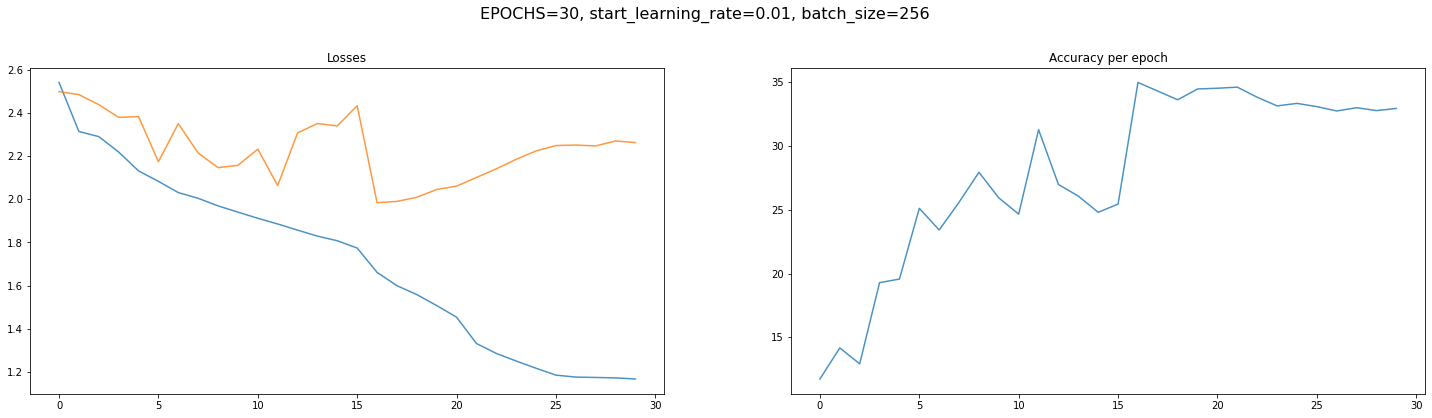

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
fig.suptitle(f'EPOCHS={EPOCHS}, start_learning_rate={start_learning_rate}, batch_size={batch_size}', fontsize=16, y=1.02)
ax[0].plot(train_history, alpha=0.8, label='Training loss')
ax[0].plot(val_history, alpha=0.8, label='Validation loss')
ax[0].set_title('Losses')
ax[1].plot(val_accuracy, alpha=0.8, label='Accuracy')
ax[1].set_title('Accuracy per epoch');

In [ ]:
# явное переобучение

In [ ]:
dir_path = '/content/sample_data/'
torch.save(net,dir_path+f'resnet_50_pretrained_{EPOCHS}.pt')  # выгрузили веса модели

In [ ]:
def dog_recognizer(path, show=False):
  net.eval()
  with torch.no_grad():
    img,label = resizer(path, mode='val').values()
    x = torch.from_numpy(img).float().reshape(1, 3, 100, 100).to(device)
    y_pred = torch.argmax(net(x))
    if show:
      plt.imshow(img)
      plt.suptitle(label);
    return y_pred

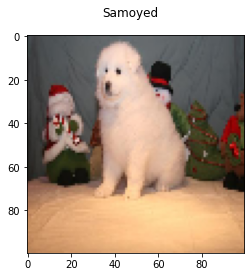

In [ ]:
img = test_csv['path'][0]
output = dog_recognizer(img, show=True)

In [ ]:
print(output, labels[output])

tensor(8, device='cuda:0') n02111889
